In [24]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, MaxPooling1D, Dropout, InputLayer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
import matplotlib.pyplot as plt
import kagglehub

In [25]:
# Descargar y cargar el dataset
path = kagglehub.dataset_download("mnassrib/jena-climate")
df = pd.read_csv(f"{path}/jena_climate_2009_2016.csv")

# Preprocesamiento
df = df[['T (degC)']]  # Solo la temperatura
data = df.values.astype('float32')

In [26]:
# Definir parámetros del modelo
window_size = 24
batch_size = 32
n = len(data)

# Crear los datasets con ventanas deslizantes
def create_dataset(data, start_index, end_index, window_size, batch_size):
    return timeseries_dataset_from_array(
        data[start_index:end_index],
        data[start_index + window_size:end_index + window_size],
        sequence_length=window_size,
        batch_size=batch_size
    )

# División del dataset: 80% entrenamiento, 10% validación, 10% prueba
train_dataset = create_dataset(data, 0, int(n * 0.8), window_size, batch_size)
val_dataset = create_dataset(data, int(n * 0.8), int(n * 0.9), window_size, batch_size)
test_dataset = create_dataset(data, int(n * 0.9), n, window_size, batch_size)

# Ajustar las dimensiones si es necesario
train_dataset = train_dataset.map(lambda x, y: (tf.reshape(x, (-1, window_size, 1)), y))
val_dataset = val_dataset.map(lambda x, y: (tf.reshape(x, (-1, window_size, 1)), y))
test_dataset = test_dataset.map(lambda x, y: (tf.reshape(x, (-1, window_size, 1)), y))

In [29]:
# Definir el modelo Conv1D ajustado
model_conv1d = Sequential([
    InputLayer(input_shape=(window_size, 1)),
    Conv1D(filters=64, kernel_size=5, activation='relu',
           kernel_regularizer=l2(0.01)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu',
           kernel_regularizer=l2(0.01)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1)  # Capa de salida para regresión
])

# Compilar el modelo
model_conv1d.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [30]:
# Implementar EarlyStopping para evitar sobreentrenamiento
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Entrenar el modelo con 10 épocas
history_conv1d = model_conv1d.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/10
10514/10514 ━━━━━━━━━━━━━━━━━━━━ 123s 12ms/step - loss: 1.2858 - mae: 0.5804 - val_loss: 0.9985 - val_mae: 0.7210
Epoch 2/10
10514/10514 ━━━━━━━━━━━━━━━━━━━━ 138s 11ms/step - loss: 0.4492 - mae: 0.3731 - val_loss: 0.3791 - val_mae: 0.4163
Epoch 3/10
10514/10514 ━━━━━━━━━━━━━━━━━━━━ 143s 11ms/step - loss: 0.3262 - mae: 0.3272 - val_loss: 0.2390 - val_mae: 0.2963
Epoch 4/10
10514/10514 ━━━━━━━━━━━━━━━━━━━━ 143s 11ms/step - loss: 0.2933 - mae: 0.3053 - val_loss: 0.2204 - val_mae: 0.2701
Epoch 5/10
10514/10514 ━━━━━━━━━━━━━━━━━━━━ 117s 11ms/step - loss: 0.2513 - mae: 0.2896 - val_loss: 0.2284 - val_mae: 0.2817
Epoch 6/10
10514/10514 ━━━━━━━━━━━━━━━━━━━━ 115s 11ms/step - loss: 0.2505 - mae: 0.2838 - val_loss: 0.2232 - val_mae: 0.2783


1314/1314 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.1968 - mae: 0.2529
MAE en el conjunto de prueba: 0.2609093487262726


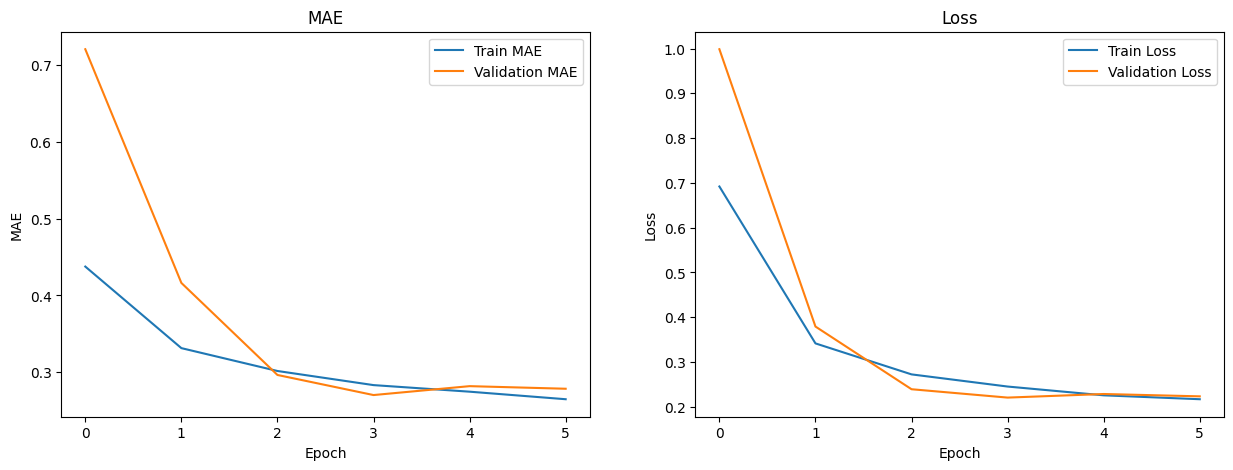

In [31]:
# Evaluar el modelo en el conjunto de prueba
loss, mae = model_conv1d.evaluate(test_dataset)
print(f'MAE en el conjunto de prueba: {mae}')

# Función para graficar el historial de entrenamiento
def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Graficar MAE
    axs[0].plot(history.history['mae'], label='Train MAE')
    axs[0].plot(history.history['val_mae'], label='Validation MAE')
    axs[0].set_title('MAE')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('MAE')
    axs[0].legend()

    # Graficar pérdida
    axs[1].plot(history.history['loss'], label='Train Loss')
    axs[1].plot(history.history['val_loss'], label='Validation Loss')
    axs[1].set_title('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    plt.show()

# Graficar el historial de entrenamiento
plot_history(history_conv1d)


# ANALISIS

El modelo Conv1D se adapta bien a la naturaleza de los datos de serie temporal. ya que aplican filtros a ventanas específicas de los datos, detectando características relevantes que se repiten en diferentes momentos. En este caso, se usaron ventanas de 24 horas para predecir la temperatura, lo que permite al modelo aprender las relaciones entre los valores pasados y futuros de la serie temporal.

## Análisis de Rendimiento del Modelo

El modelo logró adaptarse adecuadamente a los datos de serie temporal, capturando patrones significativos en las ventanas de tiempo definidas. El modelo identificó relaciones relevantes entre las temperaturas pasadas y futuras. La combinación de capas convolucionales con MaxPooling ayudó a reducir la complejidad del modelo, mientras que la regularización L2 evitó el sobreajuste. Esta estructura permitió mantener la consistencia entre los conjuntos de entrenamiento, validación y prueba.

Anteriormente se tenia tambien dropout pero el modelo se limitaba mucho por lo que tenia comportamientos perdidos es decir que no lograba generalizar.

## Conjunto de entrenamiento:

Durante el entrenamiento, las métricas mostraron una clara mejora, con el MAE disminuyendo de 0.5804 en la primera época a 0.2529 en la última. Esta caída constante indica que el modelo fue capaz de aprender progresivamente los patrones presentes en la serie temporal. Asimismo, la pérdida (Loss) se redujo de 1.2858 a 0.1968, lo que refleja que el modelo ajustó cada vez mejor sus predicciones a los datos de entrenamiento.

## Conjunto de validación:

En el conjunto de validación, el MAE inicial fue de 0.7210 y disminuyó hasta
 0.2783 al final del entrenamiento, lo que demuestra que el modelo fue capaz de generalizar bien a datos no vistos durante el entrenamiento. La pérdida de validación (val_loss) siguió un comportamiento similar, bajando de 0.9985 a
  0.2232, indicando que las predicciones del modelo mejoraron de manera significativa a medida que avanzaban las épocas. El hecho de que las curvas de MAE y Loss para entrenamiento y validación sean similares sugiere que no hubo un problema significativo de sobreajuste y que el modelo mantiene su capacidad predictiva más allá del conjunto de entrenamiento.